# Code for downloading rainfall data from NOAA radar

##### Note: Install the rasterio module using the command line, "conda install rasterio"



In [1]:
# Import modules
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
#from rasterio import features as ft
from rasterio.warp import calculate_default_transform, reproject, Resampling


In [2]:
# Obtain the current working directory

glob.os.getcwd()


'C:\\Users\\parkernath32\\Dropbox\\Nathaniel Parker\\KSU_Coursework\\Spring 2020\\Introduction to Scientific Programming\\semester_project'

In [3]:
# User inputs

SOI = input('Enter station name')
lat_SOI = float(input('Enter latitude'))
lon_SOI = float(input('Enter longitude'))
#interval = input('Enter data interval')
#start =input('Enter start date in mm-dd-yyyy')
#end =input('Enter end date in mm-dd-yyyy')
#email = input('Enter recipient email address')


Enter station name manhattan
Enter latitude 36
Enter longitude -96


In [4]:
# Creating a Haversine function for computing the distance between two points on the earth's surface

def haversine (lat1,lon1,lat2,lon2):
    " A Function for calculating the distance between two points on the earth's surface using the Haversine formula"
    
    import math
    
    R = 6371000  # radius of the earth in meters
    a = math.sin(math.radians((lat1-lat2)/2))**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(math.radians((lon1-lon2)/2))**2
    if a < 0:
        print('row',row,'col',col,':', 'Error: sqrt(a) is undefined, a is negative')
    elif a >= 1:
        print('row',row,'col',col,':', 'Error: sqrt(1-a) is undefined, a is > or = 1')
    else:
        b = 2* math.atan2(math.sqrt(a), math.sqrt(1-a))
        row_col = (row,col)
        d = round(R*b/1000,3) # converting the distance from m to km
        return d #, row_col
    


In [5]:
# Load a single file to explore the data information
data_file = 'nws_precip_last365days_20200426_conus.tif'
data = rasterio.open(data_file)

print(data)

print(data.shape)
print(data.width)
print(data.height)
print(data.indexes)
print(data.bounds)
print(data.crs)


<open DatasetReader name='nws_precip_last365days_20200426_conus.tif' mode='r'>
(881, 1121)
1121
881
(1, 2, 3, 4)
BoundingBox(left=-1904912.11073866, bottom=-7619986.69569394, right=3434410.88926134, top=-3423783.69569394)
PROJCS["NOAA_HRAP_Grid",GEOGCS["GCS_NOAA_HRAP",DATUM["D_NOAA_HRAP",SPHEROID["Sphere",6371200,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",60],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [6]:

# Create a function to convert the coordinates reference system of the data file from EPSG: 9001 to EPSG: 4326

def reproject_et(inpath, outpath, new_crs):
    
    'A function to convert a raster from one coordinate system to another coordinate system. This function will load back into into python the new file created'
    'Definition of inputs: inpath = name of the file which is to be converted'
    'outpath = name of the new file after the conversion'  
    'new_crs = the new refrence system you want'
   
    dst_crs = new_crs # CRS for web meractor 

    with rasterio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                

In [7]:
# Convert the data into the new coordinte system

new_crs = 'EPSG:4326'
inpath = data_file
outpath = 'data_new.tif'
reproject_et(inpath,outpath,new_crs)

# open the new file to python

data = rasterio.open(outpath) 
print(data.crs)
print(data.shape)
print(data.bounds)
print(data.meta)




EPSG:4326
(860, 1675)
BoundingBox(left=-134.09052600184998, bottom=19.79185248033106, right=-59.93204480938164, top=57.86725177915063)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1675, 'height': 860, 'count': 4, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.044273720114906476, 0.0, -134.09052600184998,
       0.0, -0.044273720114906476, 57.86725177915063)}


In [8]:
# Create empty matrix

row = data.shape[0]
col = data.shape[1]
new_file = [file for file in glob.glob("data_new.tif")]
rainfall_3d = np.ones([row,col,len(new_file)]) * np.nan # here

# Append rainfall to build a 3D array

rainfall = data.read(1)  # band 1 contains the observed rainfall
idx_no_us = data.read(1)<0
rainfall[idx_no_us] = np.nan  # convert negative values to NaNs
rainfall_3d[:,:,0] = rainfall
rainfall_3d.shape


(860, 1675, 1)

In [9]:
# Compute cumulative rainfall for each single pixel

cum_rainfall = np.nansum(rainfall_3d, axis=2) # rainfall in inches
cum_rainfall = cum_rainfall * 25.4  # inches to millimeters

# Inspect rainfall in some of the pixels
cum_rainfall[600,800]


695.0000198364257

In [10]:
# Set to `NaN` all the pixels that are outside the PRISM US boundaries and are equal to zero

cum_rainfall[idx_no_us | (cum_rainfall == 0)] = np.nan


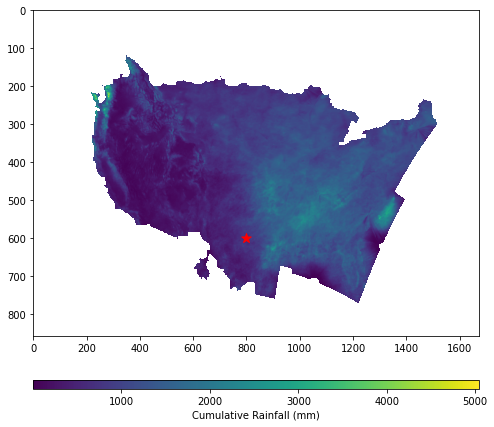

In [11]:
# Plot Map of cummulative rainfall

plt.figure(figsize=(8,8))
plt.imshow(cum_rainfall, aspect='auto')
plt.colorbar(orientation="horizontal", pad=0.1, aspect=50, label="Cumulative Rainfall (mm)")
plt.scatter(800, 600, marker='*', color='r', s=100)
plt.gca().axes.get_xaxis().set_visible(True)
plt.gca().axes.get_yaxis().set_visible(True)
plt.show()


In [28]:
# Compute the distance between SOI and the varous coordinates of the map 

minimum_distance = 100000000000
distances = [] # in km
for row in range(data.shape[0]):
    for col in range(data.shape[1]):
        distances.append(haversine(lat_SOI,lon_SOI,row,col))
             

row 216 col 264 : Error: sqrt(1-a) is undefined, a is > or = 1
row 216 col 624 : Error: sqrt(1-a) is undefined, a is > or = 1
row 216 col 984 : Error: sqrt(1-a) is undefined, a is > or = 1
row 216 col 1344 : Error: sqrt(1-a) is undefined, a is > or = 1
row 324 col 84 : Error: sqrt(1-a) is undefined, a is > or = 1
row 324 col 444 : Error: sqrt(1-a) is undefined, a is > or = 1
row 324 col 804 : Error: sqrt(1-a) is undefined, a is > or = 1
row 324 col 1164 : Error: sqrt(1-a) is undefined, a is > or = 1
row 324 col 1524 : Error: sqrt(1-a) is undefined, a is > or = 1
row 576 col 264 : Error: sqrt(1-a) is undefined, a is > or = 1
row 576 col 624 : Error: sqrt(1-a) is undefined, a is > or = 1
row 576 col 984 : Error: sqrt(1-a) is undefined, a is > or = 1
row 576 col 1344 : Error: sqrt(1-a) is undefined, a is > or = 1
row 684 col 84 : Error: sqrt(1-a) is undefined, a is > or = 1
row 684 col 444 : Error: sqrt(1-a) is undefined, a is > or = 1
row 684 col 804 : Error: sqrt(1-a) is undefined, a is

In [31]:
# Inspect the distances computed
distances[1]

10636.71

In [34]:
# Identifying the closest distance to SOI

minimum_distance = int(distances[0])
c = 0
print('guess distance:', minimum_distance)
for i in range(1,len(distances)):
    a = distances[i]
    b = distances[i-1]
    
    if a < b:
        c = a
        if c < minimum_distance:
            minimum_distance = distances[i]
    else:
        c = b
        if c < minimum_distance:
            minimum_distance = distances[i]
        
minimum_distance    

guess distance: 10546


TypeError: '<' not supported between instances of 'NoneType' and 'float'

In [35]:
# The cell before this one is not working
# This cell is to test the 

vec = [10,50,15,25,-7,35,40,50,60,7,8,9,10]
minimum = vec[0]
print(type(minimum))
#new = 0
for i in range(1,len(vec)):
    a = vec[i]
    b =  vec[i-1]
    if a < b:
        less = a
        if less<minimum:
            minimum = less
            #new= minimum

minimum

<class 'int'>


-7